# Timing Evolution for BO Stopping Criteria
This notebook pulls runtime logs from a small W&B sweep (single seed, uniform cost, 50 iterations) and visualizes the per‑iteration computation time for each stopping policy. It is easy to see that PRB dominates in computation time, even on a log scale. 

In [1]:
import os
import wandb
import pandas as pd
import matplotlib.pyplot as plt

ENTITY = "ziv-scully-group"      
PROJECT = "StoppingBayesOptSynthetic"    
SWEEP_ID = "axqam0mm"  

api = wandb.Api()
sweep_path = f"{ENTITY}/{PROJECT}/{SWEEP_ID}"
runs = api.sweep(sweep_path).runs
print(f"Loaded {len(runs)} runs from sweep {sweep_path}")

Loaded 6 runs from sweep ziv-scully-group/StoppingBayesOptSynthetic/axqam0mm


In [2]:
# keep only the configuration we care about (seed = 0, cost_type = 'uniform')
filtered_runs = []
for r in runs:
    cfg = r.config
    if cfg.get('seed', 0) == 0 and cfg.get('cost_type', 'uniform') == 'uniform':
        filtered_runs.append(r)

print(f"After filtering: {len(filtered_runs)} runs")

After filtering: 6 runs


In [ ]:
from collections import defaultdict
stopping_rules = [
    'LogEIC',
    'SRGap-med',
    #'Stable_Gittins_Lambda_1',
    #'Stable_Gittins_Lambda_01',
    #'Stable_Gittins_Lambda_001',
    'UCB-LCB',
    'PRB_0_1',
]

# heuristic mapping from rule → possible column prefixes
rule_prefix = {
    'LogEIC': 'LogEIC',
    'SRGap-med': 'Regret-Gap',
    'Stable_Gittins_Lambda_1':'StablePBGI(0.1)',
    'Stable_Gittins_Lambda_01': 'StablePBGI(0.01)',
    'Stable_Gittins_Lambda_001': 'StablePBGI(0.001)',
    'UCB-LCB': 'UCB_LCB',  # logged key used '_' not '-'
    'PRB_0_1': 'PRB_0.1',  # dot vs underscore
}

# policy_histories: {policy: {rule: pd.Series}}
policy_histories = defaultdict(dict)

for r in filtered_runs:
    policy = r.config.get('policy', r.name)
    hist = r.history(samples=1000)

    for rule in stopping_rules:
        pref = rule_prefix.get(rule, rule)
        # find column that contains the prefix and ends with 'time'
        cols = [c for c in hist.columns if pref in c and c.lower().endswith('time')]
        if not cols:
            # try exact + '_time'
            exact_col = f"{rule}_time"
            cols = [c for c in hist.columns if c == exact_col]
        if not cols:
            continue  # rule not logged in this run
        col = cols[0]

        series = (
            hist[col]
            .fillna(0)               # replace NaNs with 0 as requested
            .reset_index(drop=True)
            .iloc[:50]               # keep first 50 iterations
        )
        policy_histories[policy][rule] = series

# policy_histories

In [7]:
# build a dict of pandas Series: {policy: runtime per iteration}
policy_histories = {}
for r in filtered_runs:
    policy = r.config.get('policy', r.name)
    # fetch full history (50 iterations ≈ <100 rows)
    hist = r.history(samples=1000)

    # guess the runtime column name
    runtime_col = None
    for c in hist.columns:
        if c.endswith("_time"):
            runtime_col = c
            break
    if runtime_col is None:
        print(f"[warning] no runtime column for run {r.name} (policy={policy}) – skipped")
        continue

    # ensure exactly 50 iterations, drop NaNs at the front if any
    series = (
        hist[runtime_col]
        .fillna(0)                # convert NaNs → 0 for plotting/analysis
        .reset_index(drop=True)
        .iloc[:50]
    )
    policy_histories[policy] = series

# print(policy_histories)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.4
})

plt.style.use('seaborn-v0_8-bright')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'legend.fontsize': 14,
    # 'xtick.rotation': 45,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.autolayout': False,  # we’ll call tight_layout() explicitly
})

In [21]:
color_dict = {
    'LogEIC':                  'tab:orange',
    'LogEIWithCost':           'tab:blue',
    'LogEIC-med':              'tab:blue',
    'Stable_Gittins_Lambda_1': 'tab:orange',
    'Stable_Gittins_Lambda_01':'tab:orange',
    'Stable_Gittins_Lambda_001':'tab:orange',
    'UpperConfidenceBound':    'tab:purple',
    'UCB-LCB':                 'tab:purple',
    'SRGap-med':               'tab:pink',
    'ThompsonSampling':        'tab:brown',
    'PRB_0_1':                 'tab:brown',
    'GSS':                     'tab:olive',
    'Convergence':             'tab:gray',
    'Hindsight':               'tab:red'
}

name_dict = {
    0.1: "λ = 0.1",
    0.01: "λ = 0.01",
    0.001: "λ = 0.001", 
    'Stable_Gittins_Lambda_1': "PBGI(0.1)",
    'Stable_Gittins_Lambda_01': "PBGI(0.01)",
    'Stable_Gittins_Lambda_001':"PBGI(0.001)",
    'LogEIWithCost':"LogEIC", 
    'UpperConfidenceBound': "LCB", 
    'ThompsonSampling': "TS", 
    'PRB_0_1': "PRB",
    'LogEIC': "PBGI/LogEIC",
    'LogEIC-med':"LogEIC-med", 
    'UCB-LCB': "UCB-LCB",
    'Convergence': "Convergence",
    'GSS': "GSS",
    'SRGap-med':"SRGap-med",
    'uniform': "Uniform Cost",
    'linear': "Linear Cost",
    'periodic': "Periodic Cost" 
}

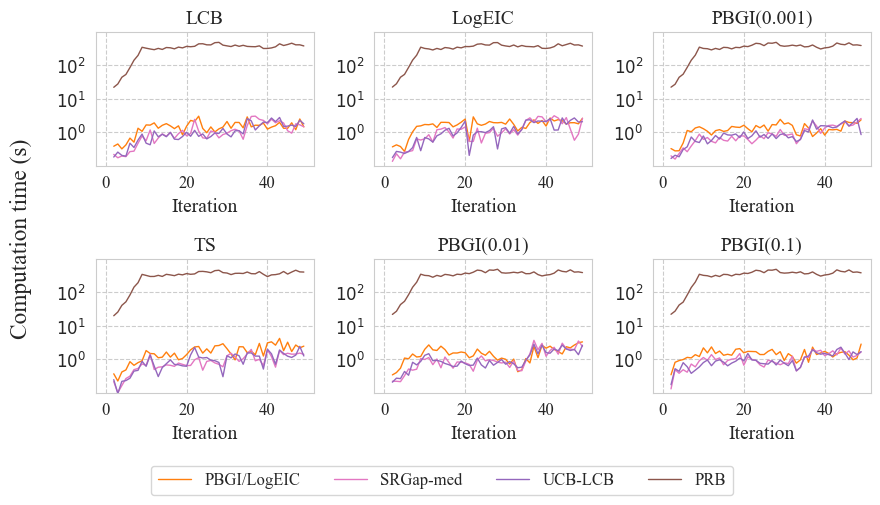

In [55]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def log10_formatter(x, pos):
    """Return tick label as 10^k."""
    k = int(round(math.log10(x)))
    return fr"$10^{k}$"

policies = [p for p, rd in policy_histories.items() if rd]   # skip empty ones
n_pols   = len(policies)

# choose a grid shape—square-ish usually looks good
ncols = math.ceil(math.sqrt(n_pols))
nrows = math.ceil(n_pols / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols/2, 5*nrows/2), sharey=False)
axes = axes.flat if n_pols > 1 else [axes]                  # make iterable

all_handles, all_labels = [], []

for ax, policy in zip(axes, policies):
    rule_dict = policy_histories[policy]

    for rule, s in rule_dict.items():
        line, = ax.plot(
            s.index, s.values,
            lw=1,
            color=color_dict[rule],
            label=name_dict[rule]
        )
    ax.set_title(name_dict[policy])
    ax.set_xlabel("Iteration")
    # ax.set_ylabel("")
    ax.set_yscale('log')

    # collect one handle per rule (avoid duplicates)
    h, l = ax.get_legend_handles_labels()
    for handle, label in zip(h, l):
        if label not in all_labels:
            all_handles.append(handle)
            all_labels.append(label)

# hide any unused axes (if grid bigger than needed)
for ax in axes[n_pols:]:
    ax.axis("off")

for ax in axes:               
    ax.set_yscale("log")
    ax.set_ylim(0.1, 1000)       # make sure the axis actually spans 10^0–10^2
    ax.yaxis.set_major_locator(mticker.FixedLocator([1, 10, 100]))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(log10_formatter))

fig.supylabel("Computation time (s)", va="center")
# single legend centred below all subplots
fig.legend(
    all_handles, all_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=len(stopping_rules),
    fontsize=12
)

fig.tight_layout(rect=[0, 0.05, 1, 1])   # leave space for the legend

plt.savefig(f'../plots/Synthetic_RunTime.pdf', bbox_inches='tight')
plt.show()